In [1]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## radius neighbors
from sklearn.neighbors import RadiusNeighborsClassifier

# perso utils
from utils import load_data, SEED, NJOBS, dict_equality
NJOBS = 1

# get the data
X_train, X_test, Y_train, Y_test = load_data(test_size=.2)#, train_size=1000)

# scoring metrics
scoring = 'f1_weighted'


In [2]:
# rescaling the data
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

In [3]:
## model specification ##
model = RadiusNeighborsClassifier(outlier_label='most_frequent')

# hyper parameter space
param_grid = {
    # 'radius': np.concatenate((np.arange(.1, 1, .1), np.arange(1,10))),
    'radius': np.linspace(.5, 3, 6),
    # 'weights' : ['uniform', 'distance'],
    # 'metric' : ['l1', 'l2']
}

# fit the data
search_model = GridSearchCV(
    model, 
    param_grid, 
    scoring=scoring, 
    n_jobs=NJOBS,
    return_train_score=True,
)

fit = True
save = True

if fit :
    # fit the model 
    search_model.fit(X_train, Y_train)

    if save : 
        # save the model 
        with open('pkl/radnn.pkl', 'wb') as f :
            pickle.dump(search_model, f)

else : 
    # load the model
    with open('pkl/radnn.pkl', 'rb') as f :
        search_model = pickle.load(f)

    old_grid = param_grid
    param_grid = search_model.param_grid
    
    if not dict_equality(old_grid, param_grid) : 
        print('warning, param_grid changed\nthe one of the model : ')
        print(param_grid)

### results

In [9]:
print("Best Score: ", search_model.best_score_)
print("Best Params: ", search_model.best_params_, '\n')

res = search_model.cv_results_
df_res = pd.DataFrame(res)
# df_res.head()

Best Score:  0.9031821556480086
Best Params:  {'metric': 'l1', 'radius': 1.5, 'weights': 'uniform'} 



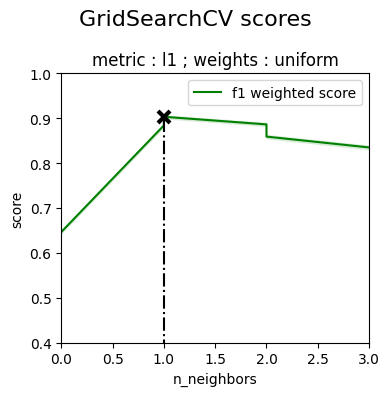

In [10]:
df_interest = df_res[['param_metric', 'param_weights', 'param_radius', 'mean_test_score', 'std_test_score']]

nrows = len(param_grid['metric'])
ncols = len(param_grid['weights'])

fig = plt.figure(figsize=(4*ncols, 4*nrows))
fig.suptitle('GridSearchCV scores', fontsize=16)


for i, (group, df) in enumerate(df_interest.groupby(by=['param_metric', 'param_weights'])) :
    df = df.sort_values(by=['param_radius'])

    x = df['param_radius'].to_numpy(dtype=int)
    score = df['mean_test_score'].to_numpy(dtype=float)
    std = df['std_test_score'].to_numpy(dtype=float)
    

    if i == 0 :
        ax = fig.add_subplot(nrows, ncols, i+1)
    else :
        ax = fig.add_subplot(nrows, ncols, i+1, sharex=ax0, sharey=ax0)


    ax.set_xlim(min(x), max(x))
    ax.set_ylim(.4, 1)

    ax.plot(x, score, color='g', label='f1 weighted score')
    ax.fill_between(x, score-std, score+std, alpha=.1, color='g')

    best_index = np.where(score == max(score))[0][0]
    b_x = x[best_index]
    b_score = score[best_index]

    ax.plot([b_x]*2, [0, b_score], linestyle="-.", color='black', marker="x", markeredgewidth=3, ms=8)

    ax.set_title('metric : {} ; weights : {}'.format(*group))
    ax.set_xlabel('n_neighbors')
    ax.set_ylabel('score')
    ax.legend()

    if i == 0 : ax0 = ax
    
fig.tight_layout()
fig.savefig('fig/knn.png')
